## Import library

In [1]:
import os
import pickle

import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
import np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

#### - load features data

In [2]:
# for natural sorting
import re

def tryint(s):
    try:
        return int(s)
    except:
        return s
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]
def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
    
dir_path = "/tmp/elias/emotion_recognition/features"

dir_list = os.listdir(dir_path)
dir_list.sort()
dir_list.pop(0)
sort_nicely(dir_list)

dir_list = dir_list[:800]
print(len(dir_list))

path = "/tmp/elias/emotion_recognition/features/"
features_data = []
count = 0
for file in dir_list:
    data = np.loadtxt(path+file, delimiter=',',skiprows=1, usecols=range(1,13))
    features_data.append(data)
#     print(count)
#     count +=1

print("length of features data :", len(features_data))

800
length of features data : 800


#### - load labels data

In [3]:
dir_list_ = os.listdir("/tmp/elias/emotion_recognition/data")
dir_list_.sort()
dir_list_ = dir_list_[:20]
label = []

# for file in dir_list_:
#     dat_file = '/tmp/elias/emotion_recognition/data/' + file
#     with open(dat_file, 'rb') as f:
#         Channel_data =pickle.load(f,encoding='latin1')
#     labels = Channel_data["labels"]
#     for value in labels:
#         if value[0] < 5:
#             Valence=0
#             if value[1] < 5:
#                 Aroucal=0
#                 tmp = [1,0,0,0]
#             else:
#                 Aroucal=1
#                 tmp = [0,0,1,0]
#         if value[0] >= 5:
#             Valence=1
#             if value[1] < 5:
#                 Arousal=0
#                 tmp = [0,1,0,0]
#             else:
#                 Aroucal=1
#                 tmp = [0,0,0,1]
#         label.append(tmp)

for file in dir_list_:
    dat_file = '/tmp/elias/emotion_recognition/data/' + file
    with open(dat_file, 'rb') as f:
        Channel_data =pickle.load(f,encoding='latin1')
    labels = Channel_data["labels"]
    for value in labels:
        if value[0] < 5:
            if value[1] < 5:
                label.append(0) # [0 0 0 0] V=0, A=0
            else:
                label.append(1) # [0 1 0 0] V=0, A=1
        else:
            if value[1] < 5:
                label.append(2) # [0 0 1 0] V=1, A=0
            else:
                label.append(3) # [0 0 0 0] V=1, A=1
                
# print("length of Arousal labels data :", len(labels_Arousal), "length of Valence labels data :", len(labels_Valence))

## Load data

## Assign GPU memory

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-02-10 23:44:10.292558: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-10 23:44:10.325369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-10 23:44:10.325725: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-02-10 23:44:10.328082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-10 23:44:10.330130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-02-10 23:44:10.330459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

## Split data into train and test
- what we have to do for this
 - 동영상 기준? ㅁ
 - 샘플 기준?

In [5]:
# train 80%, test 20%
train_data = features_data[:672]
test_data = features_data[672:]
train_data_labels = label[:672]
test_data_labels = label[672:]
print(len(train_data))
print(len(test_data))
print(len(label))
print(len(train_data_labels))

672
128
800
672


_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6000 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5)
2022-02-10 23:44:10.585108: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c40c8e9700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-02-10 23:44:10.585129: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


## Set train and test data

In [6]:
x_train_data = np.array(train_data)
y_train_data = np.array(train_data_labels)
x_test_data = np.array(test_data)
y_test_data = np.array(test_data_labels)
x_train_data.shape , y_train_data.shape

# normalize data
Train_nsamples, Train_nx, Train_ny = x_train_data.shape
train_dataset = x_train_data.reshape((Train_nsamples,Train_nx*Train_ny))
Test_nsamples, Test_nx, Test_ny = x_test_data.shape
test_dataset = x_test_data.reshape((Test_nsamples,Test_nx*Test_ny))
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_data = scaler.fit_transform(train_dataset)
x_test_data = scaler.fit_transform(test_dataset)

###
X_train = x_train_data.reshape((Train_nsamples, Train_nx, Train_ny))
X_test = x_test_data.reshape((Test_nsamples, Test_nx, Test_ny))
Y_train = to_categorical(np.reshape(y_train_data,(len(y_train_data),1)))
Y_test = to_categorical(np.reshape(y_test_data,(len(y_test_data),1)))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(672, 6337, 12)
(128, 6337, 12)
(672, 4)


## Build RNN, LSTM, GRU model

In [7]:
# Set Hyperparameters of the model
learning_rate = 0.001
epochs = 200
batch_size=64

In [8]:
X_train[0].shape

(6337, 12)

### Binary Classification

### Softmax

In [9]:
# one GRU layers with three dense layers-> IT WORKS !
model = Sequential()
model.add(GRU(units=128,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=X_train[0].shape))

# Dense net
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=120)]

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               54528     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 88,580
Trainable params: 88,580
Non-trainable params: 0
_________________________________________________________________


In [10]:
history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test,Y_test),
                  callbacks=callback_list,
                  verbose=1)

Train on 672 samples, validate on 128 samples
Epoch 1/200


2022-02-10 23:44:14.523148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


672/672 [==============================] - 158s 235ms/sample - loss: 1.3794 - accuracy: 0.3065 - val_loss: 1.3272 - val_accuracy: 0.4297
Epoch 2/200
672/672 [==============================] - 153s 227ms/sample - loss: 1.3809 - accuracy: 0.3214 - val_loss: 1.3178 - val_accuracy: 0.4375
Epoch 3/200
672/672 [==============================] - 165s 246ms/sample - loss: 1.3741 - accuracy: 0.3259 - val_loss: 1.3390 - val_accuracy: 0.4219
Epoch 4/200
672/672 [==============================] - 160s 239ms/sample - loss: 1.3719 - accuracy: 0.3274 - val_loss: 1.3379 - val_accuracy: 0.4453
Epoch 5/200
672/672 [==============================] - 156s 232ms/sample - loss: 1.3746 - accuracy: 0.3155 - val_loss: 1.3469 - val_accuracy: 0.4453
Epoch 6/200
672/672 [==============================] - 152s 226ms/sample - loss: 1.3714 - accuracy: 0.3155 - val_loss: 1.3493 - val_accuracy: 0.4453
Epoch 7/200
672/672 [==============================] - 153s 227ms/sample - loss: 1.3696 - accuracy: 0.3229 - val_loss:

## PLOT

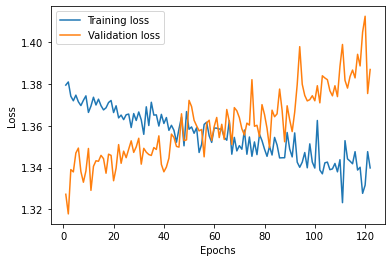

<Figure size 432x288 with 0 Axes>

In [12]:
epoch = np.arange(1,122+1)
plt.plot(epoch, history.history['loss'], label='Training loss')
plt.plot(epoch, history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('CategoricalCrossentropy_Dense2-Loss')

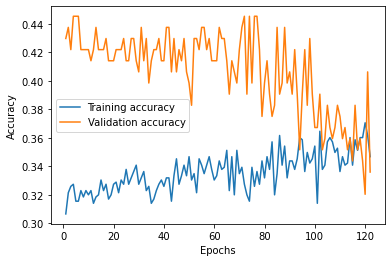

<Figure size 432x288 with 0 Axes>

In [13]:
epoch = np.arange(1,122+1)
plt.plot(epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('CategoricalCrossentropy_Dense2-Accuracy')

In [14]:
model.save('CategoricalCrossentropy_Dense2.h5')